# LSTM Classification

goal: create and research classification results of an LSTM on stock market data.

In [1]:
# import the important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, accuracy_score
from tensorflow.keras import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

### Read in the data

In [2]:
spy_df = pd.read_csv('../../data/SPY_1993-01-29_2022-08-17.csv')
spy_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1993-01-29,43.96875,43.96875,43.75000,43.93750,25.438103,1003200
1,1993-02-01,43.96875,44.25000,43.96875,44.25000,25.619028,480500
2,1993-02-02,44.21875,44.37500,44.12500,44.34375,25.673309,201300
3,1993-02-03,44.40625,44.84375,44.37500,44.81250,25.944679,529400
4,1993-02-04,44.96875,45.09375,44.46875,45.00000,26.053232,531500


In [3]:
# setting the index here cause I will have to do it multiple times
spy_df.Date = pd.to_datetime(spy_df.Date)
spy_df = spy_df.set_index('Date')
spy_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-01-29,43.968750,43.968750,43.750000,43.937500,25.438103,1003200
1993-02-01,43.968750,44.250000,43.968750,44.250000,25.619028,480500
1993-02-02,44.218750,44.375000,44.125000,44.343750,25.673309,201300
1993-02-03,44.406250,44.843750,44.375000,44.812500,25.944679,529400
1993-02-04,44.968750,45.093750,44.468750,45.000000,26.053232,531500
...,...,...,...,...,...,...
2022-08-11,422.989990,424.950012,419.209991,419.989990,419.989990,59489700
2022-08-12,422.029999,427.209991,421.029999,427.100006,427.100006,61644600
2022-08-15,424.769989,429.410004,424.709991,428.859985,428.859985,54048300


## Define inputs to be used in the model

 - Accumulation/Distribution Line - determines if money is flowing into or out of a security
 - Moving Average Convergence/Divergence - comparing 2 moving averages
  - needs an additional signal line 9-day Exponential Moving Average(EMA) of MACD
 - Relative Strength Indicator(RSI) to balance out MACD

### create the dataframe with data I will be using

In [4]:
# first get data with only Close and Volume with a date index
data_df = spy_df[['Adj Close', 'Volume']]
data_df = data_df.rename(mapper={'Adj Close': 'Adj_Close'}, axis=1)
data_df

,Adj_Close,Volume
Date,,
1993-01-29,25.438103,1003200
1993-02-01,25.619028,480500
1993-02-02,25.673309,201300
1993-02-03,25.944679,529400
1993-02-04,26.053232,531500
...,...,...
2022-08-11,419.989990,59489700
2022-08-12,427.100006,61644600
2022-08-15,428.859985,54048300


### Calculate the Accumulation/Distribution line:

$$
Money\ Flow\ Multiplier(MFM) = \frac{(Close - Low) - (High - Close)}{High - Low}
$$

$$
Money\ Flow\ Volume = MFM * Period\ Volume
$$

$$
A/D = Previous\ A/D + Current\ Money\ Flow\ Volume
$$

In [5]:
multiplier = ((spy_df.Close - spy_df.Low) - (spy_df.High - spy_df.Close)) / (spy_df.High - spy_df.Low)
multiplier

Date
1993-01-29    0.714286
1993-02-01    1.000000
1993-02-02    0.750000
1993-02-03    0.866667
1993-02-04    0.700000
                ...   
2022-08-11   -0.728224
2022-08-12    0.964406
2022-08-15    0.765950
2022-08-16    0.162888
2022-08-17   -0.149198
Length: 7442, dtype: float64

In [6]:
MFVolume = multiplier * spy_df.Volume
MFVolume

Date
1993-01-29    7.165714e+05
1993-02-01    4.805000e+05
1993-02-02    1.509750e+05
1993-02-03    4.588133e+05
1993-02-04    3.720500e+05
                  ...     
2022-08-11   -4.332185e+07
2022-08-12    5.945042e+07
2022-08-15    4.139831e+07
2022-08-16    9.657476e+06
2022-08-17   -9.469238e+06
Length: 7442, dtype: float64

In [7]:
accum_dist_indicator = MFVolume.cumsum()
accum_dist_indicator

Date
1993-01-29    7.165714e+05
1993-02-01    1.197071e+06
1993-02-02    1.348046e+06
1993-02-03    1.806860e+06
1993-02-04    2.178910e+06
                  ...     
2022-08-11    3.969710e+10
2022-08-12    3.975655e+10
2022-08-15    3.979795e+10
2022-08-16    3.980761e+10
2022-08-17    3.979814e+10
Length: 7442, dtype: float64

Let's see how our indicator line turned out

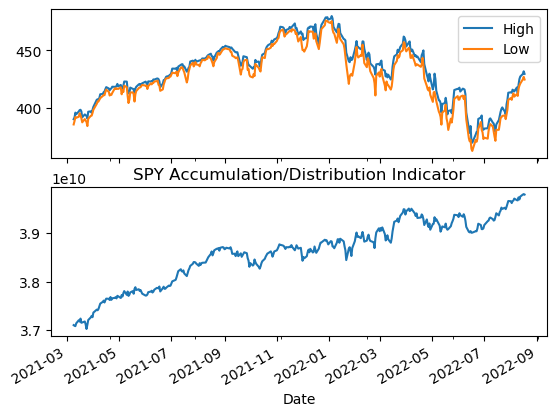

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)

accum_dist_indicator[-365:].plot(ax=axes[1])
spy_df[['High', 'Low']][-365:].plot(ax=axes[0])
axes[1].set_title('SPY Accumulation/Distribution Indicator');

#### Note: we will rescale these numbers to fit into an LSTM later

for now we just add the column to our data

In [9]:
data_df = pd.concat([data_df, accum_dist_indicator], axis=1)
data_df = data_df.rename(mapper={0:'accum_dist_indicator'}, axis=1)
data_df

,Adj_Close,Volume,accum_dist_indicator
Date,,,
1993-01-29,25.438103,1003200,7.165714e+05
1993-02-01,25.619028,480500,1.197071e+06
1993-02-02,25.673309,201300,1.348046e+06
1993-02-03,25.944679,529400,1.806860e+06
1993-02-04,26.053232,531500,2.178910e+06
...,...,...,...
2022-08-11,419.989990,59489700,3.969710e+10
2022-08-12,427.100006,61644600,3.975655e+10
2022-08-15,428.859985,54048300,3.979795e+10


### Calculating MACD

$$
MACD = EMA_{12} - EMA_{26}
$$

need that and also an inicator line which is just an $EMA_9$ of MACD

In [10]:
EMA_12 = spy_df.Close.ewm(span=12, adjust=False).mean()
EMA_26 = spy_df.Close.ewm(span=26, adjust=False).mean()
macd = EMA_12 - EMA_26
signal = macd.ewm(span=9, adjust=False).mean()

Let's take a look before adding the values to the data

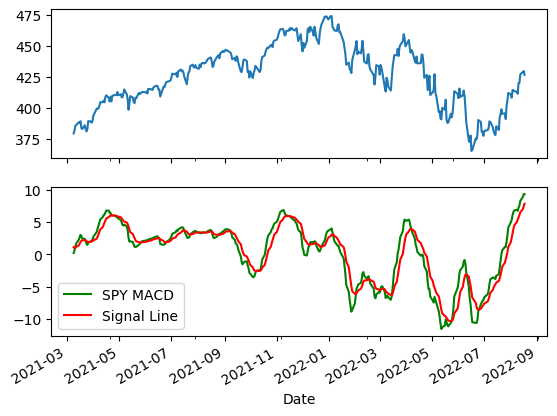

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)

macd[-365:].plot(ax=axes[1], color='g', label='SPY MACD')
signal[-365:].plot(ax=axes[1], color='r', label='Signal Line')
data_df[-365:].Adj_Close.plot(ax=axes[0], label='SPY')
axes[1].legend(loc='best')
plt.show();

Looking pretty good, lets add the MACD and signal

In [12]:
data_df = pd.concat([data_df, macd.rename('macd'), signal.rename('signal_macd')], axis=1)
data_df

,Adj_Close,Volume,accum_dist_indicator,macd,signal_macd
Date,,,,,
1993-01-29,25.438103,1003200,7.165714e+05,0.000000,0.000000
1993-02-01,25.619028,480500,1.197071e+06,0.024929,0.004986
1993-02-02,25.673309,201300,1.348046e+06,0.051654,0.014319
1993-02-03,25.944679,529400,1.806860e+06,0.109398,0.033335
1993-02-04,26.053232,531500,2.178910e+06,0.168349,0.060338
...,...,...,...,...,...
2022-08-11,419.989990,59489700,3.969710e+10,7.544738,6.085848
2022-08-12,427.100006,61644600,3.975655e+10,8.266341,6.521946
2022-08-15,428.859985,54048300,3.979795e+10,8.877893,6.993136


### Calculating RSI

In [13]:
def calc_rsi(df, periods = 14, ema = True):
    """
    Returns a pd.Series with the relative strength index.
    """
    close_delta = df['Adj_Close'].diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    if ema == True:
        # Use exponential moving average
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        # Use simple moving average
        ma_up = up.rolling(window = periods, adjust=False).mean()
        ma_down = down.rolling(window = periods, adjust=False).mean()
        
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

In [14]:
rsi = calc_rsi(data_df)
rsi = rsi.rename('rsi')
rsi

Date
1993-01-29          NaN
1993-02-01          NaN
1993-02-02          NaN
1993-02-03          NaN
1993-02-04          NaN
                ...    
2022-08-11    67.931063
2022-08-12    72.134094
2022-08-15    73.074810
2022-08-16    73.534053
2022-08-17    68.936494
Name: rsi, Length: 7442, dtype: float64

In [15]:
pd.concat([data_df, rsi], axis=1)

,Adj_Close,Volume,accum_dist_indicator,macd,signal_macd,rsi
Date,,,,,,
1993-01-29,25.438103,1003200,7.165714e+05,0.000000,0.000000,NaN
1993-02-01,25.619028,480500,1.197071e+06,0.024929,0.004986,NaN
1993-02-02,25.673309,201300,1.348046e+06,0.051654,0.014319,NaN
1993-02-03,25.944679,529400,1.806860e+06,0.109398,0.033335,NaN
1993-02-04,26.053232,531500,2.178910e+06,0.168349,0.060338,NaN
...,...,...,...,...,...,...
2022-08-11,419.989990,59489700,3.969710e+10,7.544738,6.085848,67.931063
2022-08-12,427.100006,61644600,3.975655e+10,8.266341,6.521946,72.134094
2022-08-15,428.859985,54048300,3.979795e+10,8.877893,6.993136,73.074810


## Enough Indicators for now, Framing the problem into an RNN problem

In [16]:
# make the labels first
one_diff = data_df['Adj_Close']
one_diff = one_diff.diff(-1) * -1
one_diff.dropna(inplace=True)
one_diff

Date
1993-01-29    0.180925
1993-02-01    0.054281
1993-02-02    0.271370
1993-02-03    0.108553
1993-02-04   -0.018091
                ...   
2022-08-10   -0.000000
2022-08-11    7.110016
2022-08-12    1.759979
2022-08-15    0.840027
2022-08-16   -3.050018
Name: Adj_Close, Length: 7441, dtype: float64

In [17]:
five_diff = data_df['Adj_Close']
five_diff = five_diff.diff(-5) * -1
five_diff.dropna(inplace=True)
five_diff

Date
1993-01-29     0.597038
1993-02-01     0.416113
1993-02-02     0.180904
1993-02-03    -0.054258
1993-02-04    -0.036182
                ...    
2022-08-04     5.819977
2022-08-05    13.630005
2022-08-08    15.869995
2022-08-09    18.350006
2022-08-10     6.660004
Name: Adj_Close, Length: 7437, dtype: float64

In [18]:
labels_one = one_diff > 0
labels_one = labels_one.astype(float)
labels_five = five_diff > 0
labels_five = labels_five.astype(float)
print(pd.concat([labels_one, labels_five], axis=1))

            Adj_Close  Adj_Close
Date                            
1993-01-29        1.0        1.0
1993-02-01        1.0        1.0
1993-02-02        1.0        1.0
1993-02-03        1.0        0.0
1993-02-04        0.0        0.0
...               ...        ...
2022-08-10        0.0        1.0
2022-08-11        1.0        NaN
2022-08-12        1.0        NaN
2022-08-15        1.0        NaN
2022-08-16        0.0        NaN

[7441 rows x 2 columns]


In [19]:
# next, we will transform the inputs to fit in a time series analysis problem
def series_to_supervised(data, n_in=1, col_names = [], indicies = [], dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = data
    if not isinstance(df, pd.DataFrame):
        df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    agg = pd.DataFrame()
    for i in range(n_in, 0, -1):
        agg = pd.concat([agg, df.shift(i)], axis=1)
        names += [('%s(t-%d)' % (col_names[j], i)) for j in range(n_vars)]
    # putting it together
    # agg = pd.concat(cols, axis=1)
    agg.columns = names
    agg.index = indicies
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [20]:
def prep_data(data, p_test, n_lag, stationary=False):
    '''
    series - dataset to transform
    p_test - percentage of test set size
    n_lag - number of previous days to take into account
    n_seq - number of days to predict
    stationary - boolean determining if the series should be differenced
    returns -> train, test, scaler
    '''
    # transform series into train and test sets
    ret_values = data
    if stationary:
        ret_values = data.diff().dropna()
    
    col_names = ret_values.columns
    indicies = ret_values.index
    # rescale series between (0, 1)
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_values = scaler.fit_transform(ret_values)
    
    # Transform into supervised learning problem X
    supervised = series_to_supervised(scaled_values, n_lag, col_names, indicies)
    supervised_values = supervised
    
    # supervised_values.set_index(indicies)
    # split into train and test sets
    split_val = int(len(data) * (1 - p_test))
    train, test = supervised_values[:split_val], supervised_values[split_val:]
    return train, test, scaler

In [21]:
train_df, test_df, scaler = prep_data(data_df, .2, 14)

In [22]:
train_df.head()

,Adj_Close(t-14),Volume(t-14),accum_dist_indicator(t-14),macd(t-14),signal_macd(t-14),Adj_Close(t-13),Volume(t-13),accum_dist_indicator(t-13),macd(t-13),signal_macd(t-13),...,Adj_Close(t-2),Volume(t-2),accum_dist_indicator(t-2),macd(t-2),signal_macd(t-2),Adj_Close(t-1),Volume(t-1),accum_dist_indicator(t-1),macd(t-1),signal_macd(t-1)
Date,,,,,,,,,,,,,,,,,,,,,
1993-02-19,0.000685,0.001146,0.000000,0.718424,0.717533,0.001088,0.000546,0.000012,0.719177,0.717713,...,0.000040,0.000236,0.000034,0.719492,0.722882,0.000000,0.000428,0.000034,0.717321,0.721548
1993-02-22,0.001088,0.000546,0.000012,0.719177,0.717713,0.001209,0.000225,0.000016,0.719984,0.718049,...,0.000000,0.000428,0.000034,0.717321,0.721548,0.000201,0.000034,0.000035,0.716009,0.720169
1993-02-23,0.001209,0.000225,0.000016,0.719984,0.718049,0.001813,0.000602,0.000027,0.721728,0.718735,...,0.000201,0.000034,0.000035,0.716009,0.720169,0.000403,0.000584,0.000041,0.715385,0.718916
1993-02-24,0.001813,0.000602,0.000027,0.721728,0.718735,0.002055,0.000604,0.000037,0.723509,0.719709,...,0.000403,0.000584,0.000041,0.715385,0.718916,0.000363,0.000423,0.000042,0.714856,0.717787
1993-02-25,0.002055,0.000604,0.000037,0.723509,0.719709,0.002015,0.000559,0.000042,0.724771,0.720790,...,0.000363,0.000423,0.000042,0.714856,0.717787,0.001088,0.000024,0.000042,0.715837,0.717118


In [23]:
y_train = pd.concat([train_df, labels_one.rename('labels')], axis=1).dropna()[['labels']]
y_test = pd.concat([test_df, labels_one.rename('labels')], axis=1).dropna()[['labels']]

## Once thats done, we can define and train our model

In [24]:
def fit_lstm(train, labels, n_lag, n_pred, n_batch, nb_epoch, n_neurons, n_seq):
    '''
    train - dataset to train on
    labels - the labels for fitting
    n_lag - number of previous days to take into account
    n_pred - number of days to predict
    n_batch - batch_size
    nb_epoch - epoch number
    n_neurons - number of neurons in the layer, probably going to be changed
    returns -> model
    '''
    # reshape training into [samples, timesteps, features]
    X, y = train.to_numpy(), labels.to_numpy()
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    # defining the model
    model = Sequential()
    model.add(LSTM(n_neurons,
                   batch_input_shape=(n_batch, X.shape[1], X.shape[2]),
                   stateful=True,
                   return_sequences=True,
                   dropout=.5))
    model.add(LSTM(n_neurons,
                   batch_input_shape=(n_batch, X.shape[1], X.shape[2]),
                   stateful=True,
                   return_sequences=False,
                   dropout=.5))
    model.add(Dense(y.shape[1], activation='sigmoid'))
    opt = Adam(learning_rate=0.000001)
    callbacks = [EarlyStopping(monitor='loss', patience=3)]
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy','AUC'])
    
    # fit the model
    for i in range(nb_epoch):
        if not (i%10):
            print('epoch',i,'/',nb_epoch)
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=1, shuffle=False)
        model.reset_states()
    return model

In [25]:
len(train_df)

5953

In [26]:
model = fit_lstm(train_df[1:], y_train[1:], 50, 1, 32, 10, 512, 1)
model.summary()

epoch 0 / 10
186/186 [==============================] - 2s 10ms/step - loss: 0.6908 - accuracy: 0.5338 - auc: 0.5049
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (32, 1, 512)              1193984   
                                                                 
 lstm_1 (LSTM)               (32, 512)                 2099200   
                                                                 
 dense (Dense)               (32, 1)                   513       
                                                                 
Total params: 3,293,697
Trainable params: 3,293,697
Non-trainable params: 0
_________________________________________________________________


### Now for evaluating our model

In [27]:
predictions = model.predict(test_df[3:].to_numpy().reshape((-1, 1, 70)))
predictions = predictions > predictions.mean()
predictions = predictions.reshape((-1,1))

46/46 [==============================] - 1s 6ms/step


In [28]:
print('precision = %f, recall = %f, thresh = %f' %
      (precision_score(y_test[2:].astype(bool).to_numpy(), predictions[:,0].astype(bool)),
       recall_score(y_test[2:].astype(bool).to_numpy(), predictions[:,0].astype(bool)),
       predictions.mean())
     )

precision = 0.554104, recall = 0.723508, thresh = 0.728261


In [29]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test[2:].astype(bool).to_numpy(), predictions[:,0].astype(bool))

array([[173, 478],
       [227, 594]], dtype=int64)

#### checking the five day difference now

In [30]:
y_train = pd.concat([train_df, labels_five.rename('labels')], axis=1).dropna()[['labels']]
y_test = pd.concat([test_df, labels_five.rename('labels')], axis=1).dropna()[['labels']]

In [31]:
model_five = fit_lstm(train_df[1:], y_train[1:], 50, 1, 32, 25, 512, 1)
model_five.summary()

epoch 0 / 25
186/186 [==============================] - 2s 10ms/step - loss: 0.6824 - accuracy: 0.5738 - auc: 0.5084
epoch 10 / 25
186/186 [==============================] - 2s 10ms/step - loss: 0.6824 - accuracy: 0.5739 - auc: 0.5100
epoch 20 / 25
186/186 [==============================] - 2s 10ms/step - loss: 0.6817 - accuracy: 0.5738 - auc: 0.5222
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (32, 1, 512)              1193984   
                                                                 
 lstm_3 (LSTM)               (32, 512)                 2099200   
                                                                 
 dense_1 (Dense)             (32, 1)                   513       
                                                                 
Total params: 3,293,697
Trainable params: 3,293,697
Non-trainable params: 0
_____________________

In [32]:
predictions = model_five.predict(test_df[3:].to_numpy().reshape((-1, 1, 70)))
pd.DataFrame(predictions).describe()

46/46 [==============================] - 1s 6ms/step


,0
count,1472.000000
mean,0.568050
std,0.020914
min,0.502807
25%,0.563283
50%,0.577671
75%,0.581790
max,0.585430


In [33]:
def readable(preds, thresh):
    return preds > thresh

In [34]:
preds = readable(predictions, .564)

In [35]:
print('precision = %f, recall = %f' %
      (precision_score(y_test.astype(bool).to_numpy(), preds[2:,0].astype(bool)),
       recall_score(y_test.astype(bool).to_numpy(), preds[2:,0].astype(bool)))
     )

precision = 0.631095, recall = 0.736842


In [36]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test.astype(bool).to_numpy(), preds[2:,0].astype(bool))

array([[138, 401],
       [245, 686]], dtype=int64)

TODO: create a streamlined way of generating models, tune the five day model